<a href="https://colab.research.google.com/github/pipeton8/6.439-stats-comp-applications/blob/main/Assignments/2%20-%20Genomics/6.439%20Problem%20Set%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 2 - Statistics, Computation and Applications

(c) Felipe del Canto, October 2021
***
***

# Part 0 (Execute first!)

In [1]:
from IPython.display import clear_output

# Download files
!wget https://github.com/pipeton8/6.439-stats-comp-applications/raw/main/Assignments/databases/PS2_data.zip
!wget https://github.com/pipeton8/6.439-stats-comp-applications/raw/main/Assignments/databases/PS2_data.z01
!wget https://github.com/pipeton8/6.439-stats-comp-applications/raw/main/Assignments/databases/PS2_data.z02
!wget https://github.com/pipeton8/6.439-stats-comp-applications/raw/main/Assignments/databases/PS2_data.z03
!wget https://github.com/pipeton8/6.439-stats-comp-applications/raw/main/Assignments/databases/PS2_data.z04

# Unzip
!zip -F PS2_data.zip -O PS2_data_combined.zip
!unzip -o PS2_data_combined.zip
!rm *.z* -r __MACOSX

# Clear output
clear_output()

# Import packages
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

# Part 1

## Problem 2.1

In [2]:
data_path = 'hic/'
kbp = 250e3

In [13]:
def load_data(X,Y,data_path = 'hic/',resolution = 250e3, create_log_inter = True, drop_inter = True):
  """ 
  Load sparse matrix data in chrX_chrY.txt.

  Inputs:
    - X : `int` indicating the first chromosome number.
    - Y : `int` indicating the second chromosome number.
    - data_path  : `string` indicating location of `chrX_chrX.txt` file.
    - resolution : number indicating the resolution of the interaction data.
    - create_log_inter : `boolean`. If true, creates log(1+interaction_freq)
      variable.
    - drop_inter: `boolean`. If `True`, drops `inter_freq` variable.

  Returns:
    - df : Data frame with sparse matrix data in chrX_chrY.txt. Columns are:
          * loc_X : indicates chromosome X position, adjusted by resolution.
          * loc_Y : indicates chromosome Y position, adjusted by resolution.
          * inter_freq : indicates interaction frequency. Only present if
            `drop_inter = False`.
          * log_inter_freq: equals log(1+inter_freq). Only present if
            `create_log_inter = True`.
  """

  # Load data
  df = pd.read_table(data_path+f'chr{X}_chr{Y}.txt',index_col=False, names=['loc_x', 'loc_y', 'inter_freq'])

  # Adjust for resolution and Python slicing format
  df[['loc_x','loc_y']] = df[['loc_x','loc_y']]//resolution
  
  # Create log variable
  if create_log_inter:
    df['log_inter_freq'] = np.log(df['inter_freq']+1)

  if drop_inter:
    df.drop(columns='inter_freq',inplace=True)

  return df

In [5]:
def create_interaction_matrix(df):
  """ Creates interaction matrix between chromosomes X and Y from sparse matrix 
  data in chrX_chrY.txt.

  Inputs:
    - df : Data frame with 3 columns:
        * First must indicate i position of matrix.
        * Second must indicate j position of matrix.
        * Third must indicate value of matrix entry i,j.

  Returns:
    - matrix : Matrix of size (max(loc_x), max(loc_y)) whose entry ij is the
      third column of df if the index exist and value its not NaN, and 0 otherwise.
  """

  # Transform df to numpy and obtain maximum indeces
  df = df.to_numpy()
  max_x, max_y, _ = df.max(axis=0).astype(int)

  # Initialize matrix
  matrix = np.zeros((max_x, max_y))

  for (i,j,entry) in df:
    if np.isnan(entry):
      entry = 0

    matrix[int(i)-1, int(j)-1] = entry

  return matrix 

### (a)

In [14]:
n_chromosomes = 22

# Initialize variables
N      = 0.  # Total amount of numbers to average
sum_sq = 0.  # Sum of squares of log(1 + inter_freq)
sum    = 0.  # Sum of log(1 + inter_freq)

# Read each matrix
for X in range(1,n_chromosomes):
  for Y in range(X+1,n_chromosomes+1):
    df = load_data(X,Y)

    sum    += df['log_inter_freq'].sum()
    sum_sq += (df['log_inter_freq']**2).sum()
    N      += df['log_inter_freq'].count()


mu = sum/N
sigma_sq = 1/(N-1) * (sum_sq - 1/N * sum**2)
sigma = np.sqrt(sigma_sq)

print(f"Mean = {mu:.4f}")
print(f"Std. dev = {sigma:.4f}")

Mean = 1.1311
Std. dev = 0.4019


### (b)

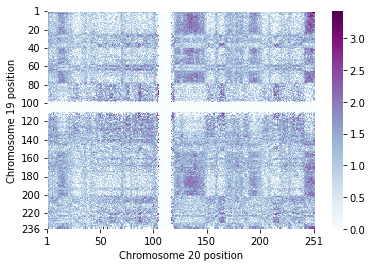

In [20]:
df = load_data(19,20)

matrix = create_interaction_matrix(df)

# Create figure
fig = plt.figure()
ax = sns.heatmap(matrix, cmap='BuPu')

# Format x axis 
ax.set_xlabel("Chromosome 20 position")
ax.set_xticks([50*k - 1 for k in range(5)]+[250])
ax.set_xticklabels(["1"] + [f"{50*k}" for k in range(1,5)]+["251"], rotation=0)

# Format y axis
ax.set_ylabel("Chromosome 19 position")
ax.set_yticks([20*k - 1 for k in range(12)]+[236])
ax.set_yticklabels(["1"] + [f"{20*k}" for k in range(1,12)]+["236"])

# Show figure
fig.show()

### (c)

### (d)

In [23]:
def greedy_search(M, mu, sigma, seed = 0, i = None, j = None):
  """
  Greedy search of contiguous, high interaction regions in matrix `m`.
 
  Inputs:
    - `m`: 2-D numpy array (matrix) where to look for interaction regions.

  Returns:
    - `sub_m`: submatrix of `m` which is a interaction region
  """

  if i is None or j is None:
    # Choose random entry
    rng = np.random.default_rng(seed)
    i,j = rng.integers(0,M.shape[0]), rng.integers(0,M.shape[1])

  # Initialize return matrix
  sub_m = M[i,j].reshape((1,1))
  current_slice = np.array([ [i,i+1], [j,j+1] ])

  # Compute p-value
  p_value_prev, _ = compute_pvalue(sub_m, M.shape, mu, sigma)
  p_value_prev = p_value_prev[0]
  
  while True:
    # Obtain 4 new matrices and the new slices from M 
    Ms, new_slices = create_next_matrices(M, current_slice)

    # Compute the p-value for each matrix 
    p_values, _ = compute_pvalue(Ms, M.shape, mu, sigma)

    # Compute the difference of each p-value with the previous one
    p_value_diff = np.min(p_values - p_value_prev)

    # If all p-values increased (or remained the same), stop
    if p_value_diff >= 0:
      break

    # Else, update sub_m, the slice and the p-value
    sub_m = Ms[p_values.argmin()]
    current_slice = new_slices[p_values.argmin()]
    p_value_prev = p_values.min()

  return sub_m, current_slice, p_value_prev

def create_next_matrices(M, slice):
  """ 
  Based on matrix M and the current slice, create 4 matrices adding the 
  following to the current slice:
    1. Column to the right.
    2. Row below.
    3. Column to the left.
    4. Row above.
  
  Returns a list of sub_matrices and their corresponding slices from M.
  """   

  # Initialize list of matrices
  Ms = []

  # Obtain slices of each of the new matrices
  new_slices = obtain_slices(M.shape, slice)

  # From new slices, retrieve the sub_matrices and add them to the list
  for slice in new_slices:
    Ms.append(M[slice[0,0]: slice[0,1], slice[1,0]:slice[1,1]])

  return Ms, new_slices

def obtain_slices(shape, initial_slice):
  """
  From a matrix shape and an initial slice, obtain the slices of the sub matrices
  that are obtained adding the following to the initial slice:
    1. Column to the right.
    2. Row below.
    3. Column to the left.
    4. Row above.
  """

  # Obtain each slice and store it in a list
  slices = [obtain_slice(shape, initial_slice, direction=direction) for direction in ['right', 'left', 'bottom', 'top']]
  
  return slices

def obtain_slice(shape, initial_slice, direction):
  """
  From a matrix shape and an initial slice, obtain the slice of the sub matrix
  that is obtained adding one of the following to the initial slice:
    - direction = 'right'  : Column to the right.
    - direction = 'bottom' : Row below.
    - direction = 'left'   : Column to the left.
    - direction = 'top'    : Row above.
  """

  # Obtain maximum values of i and j for the slices
  max_i = shape[0]
  max_j = shape[1]

  # Default is to return original slice
  slice = initial_slice

  # If direction = "right", check that is possible to increase j in 1
  if direction == 'right' and slice[1,1]+1 <= max_j+1:
    slice = np.array([[slice[0,0], slice[0,1]], [slice[1,0], slice[1,1]+1]])

  # If direction = "left", check that is possible to decrease j in 1
  elif direction == 'left' and slice[1,0]-1 >= 0:
    slice = np.array([[slice[0,0], slice[0,1]], [slice[1,0]-1, slice[1,1]]])
  
  # If direction = "bottom", check that is possible to increase i in 1
  elif direction == 'bottom' and slice[0,1]+1 <= max_i+1:
    slice = np.array([[slice[0,0], slice[0,1]+1], [slice[1,0], slice[1,1]]])
  
  # If direction = "top", check that is possible to decrease i in 1
  elif direction == 'top' and slice[0,0]-1 >= 0:
    slice = np.array([[slice[0,0]-1, slice[0,1]], [slice[1,0], slice[1,1]]])

  return slice

def compute_pvalue(Ms, shape, mu, sigma, z_stat = True):
  """
  Given a list of sub matrices, the sape of the original matrix M and a mean (mu)
  and standard deviation (sigma), compute the p-values of each submatrix using 
  the formula
      p-value = N_submatrices * (1 - \Phi((m - mu) * sqrt(k*l)/sigma))

  where
    k, l = submatrix.shape
    N_submatrices = (M.shape[0] - k + 1) * (M.shape[1] - l + 1)
    \Phi is the CDF of a standard normal distribution
  """

  # Check if Ms is a list. Otherwise transform.
  if type(Ms) is not list:
    Ms = [Ms]

  # Initialize p_values and t_stats
  p_values = np.zeros(len(Ms))
  z_stats = np.zeros(len(Ms))

  for i,m in enumerate(Ms):
    # Compute N_submatrices
    N_sub = (shape[0] - m.shape[0] + 1) * (shape[1] - m.shape[1] + 1)

    # Compute z statistic
    z = (m.mean() - mu) * np.sqrt(m.shape).prod() / sigma

    # Add z statistic and p value to array
    z_stats[i] = z
    p_values[i] = N_sub * (1 - norm.cdf(z))

  if z_stat:
    return p_values, z_stats
  else:
    return p_values

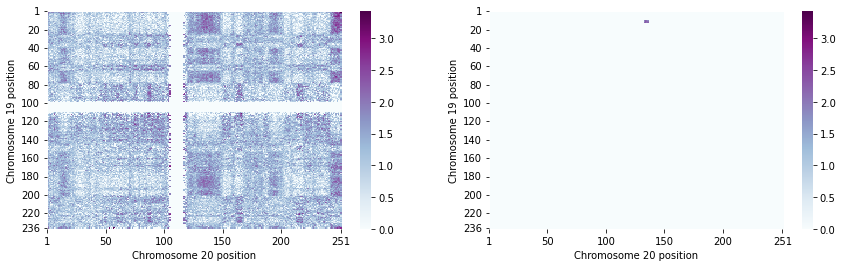

In [33]:
df = load_data(19,20)

M = create_interaction_matrix(df)

sub_m, slice, pvalue = greedy_search(M,mu,sigma, i=10,j=135)

stored_regions = np.zeros_like(M)
stored_regions[slice[0,0]:slice[0,1], slice[1,0]: slice[1,1]] = sub_m

fig, axs = plt.subplots(ncols=2)
plt.subplots_adjust(right=2)

sns.heatmap(M, cmap='BuPu', ax = axs[0])
sns.heatmap(stored_regions, cmap = 'BuPu', vmin = M.min(), vmax=M.max(), ax=axs[1])

for i in range(2):
  axs[i].set_xlabel("Chromosome 20 position")
  axs[i].set_xticks([50*k - 1 for k in range(5)]+[250])
  axs[i].set_xticklabels(["1"] + [f"{50*k}" for k in range(1,5)]+["251"], rotation=0)

  axs[i].set_ylabel("Chromosome 19 position")
  axs[i].set_yticks([20*k - 1 for k in range(12)]+[235])
  axs[i].set_yticklabels(["1"] + [f"{20*k}" for k in range(1,12)]+["236"])


fig.show()

In [37]:
def overall_greedy_search(M, mu, sigma, threshold = 0.01, verbose = True, print_every = 10):
  interacting_regions = np.zeros_like(M)
  inter_pairs = 0
  demeaned_M = M

  init_seed = -1
  step = 0

  while True:
    init_seed += 1
    step += 1

    sub_m, slice, p_value = find_interacting_region(demeaned_M,mu,sigma,threshold=threshold, init_seed=init_seed)

    if verbose and (step == 1 or step % print_every == 0):
      print(f"Step {step:3d} current p-value: {p_value:.4f}.")

    if p_value > threshold:
      if verbose and step % print_every != 0 and step != 1:
        print(f"Step {step:3d} current p-value: {p_value:.4f}.")
        print("End!")

      break

    interacting_regions[slice[0,0] : slice[0,1], slice[1,0]: slice[1,1]] = sub_m
    inter_pairs += sub_m.size

    demeaned_M[slice[0,0] : slice[0,1], slice[1,0]: slice[1,1]] -= np.ones_like(sub_m) * sub_m.mean()

  return interacting_regions, inter_pairs

def find_interacting_region(M,mu,sigma,threshold=0.01, max_rep = 100, init_seed=0): 
  for i in range(max_rep):
    sub_m, slice, p_value = greedy_search(M,mu,sigma,seed=init_seed+i)

    if p_value <= threshold:
      return sub_m, slice, p_value

  return None, None, threshold+1

Step   1 current p-value: 0.0000.
Step  10 current p-value: 0.0000.
Step  20 current p-value: 0.0000.
Step  30 current p-value: 0.0000.
Step  40 current p-value: 0.0000.
Step  50 current p-value: 0.0000.
Step  60 current p-value: 0.0000.
Step  70 current p-value: 0.0000.
Step  80 current p-value: 0.0000.
Step  88 current p-value: 1.0100.
End!


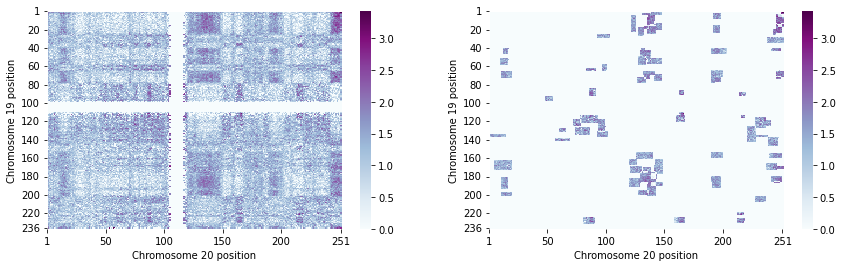

In [35]:
df = load_data(19,20)

M = create_interaction_matrix(df)
interacting_regions, inter_pairs = overall_greedy_search(M,mu,sigma)

fig, axs = plt.subplots(ncols=2)
plt.subplots_adjust(right=2)

sns.heatmap(matrix, cmap='BuPu', ax = axs[0])
sns.heatmap(interacting_regions, cmap = 'BuPu', vmin = matrix.min(), vmax=matrix.max(), ax=axs[1])

for i in range(2):
  axs[i].set_xlabel("Chromosome 20 position")
  axs[i].set_xticks([50*k - 1 for k in range(5)]+[250])
  axs[i].set_xticklabels(["1"] + [f"{50*k}" for k in range(1,5)]+["251"], rotation=0)

  axs[i].set_ylabel("Chromosome 19 position")
  axs[i].set_yticks([20*k - 1 for k in range(12)]+[235])
  axs[i].set_yticklabels(["1"] + [f"{20*k}" for k in range(1,12)]+["236"])

fig.show()

### (e)

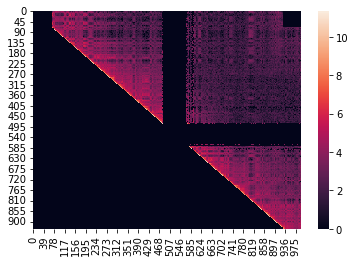

In [60]:
df = load_data(1,1)
M2 = create_interaction_matrix(df)
sns.heatmap(M2)

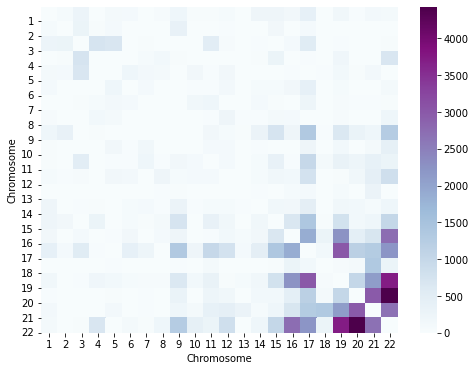

In [63]:
# n_chromosomes = 22

# from tqdm.auto import tqdm, trange

# inter_chrom_counts = np.zeros((n_chromosomes,n_chromosomes))

# for X in tqdm(range(1,n_chromosomes+1), desc="Chromosome X"):
#   for Y in tqdm(range(X+1, n_chromosomes+1), desc="Chromosome Y", leave=False):
#     df = load_data(X,Y)

#     M = create_interaction_matrix(df)
#     _, inter_pairs = overall_greedy_search(M,mu,sigma,verbose=False)

#     inter_chrom_counts[X-1,Y-1] = inter_pairs

# print("Done!")

# inter_chrom_counts += inter_chrom_counts.transpose()

# for i in range(n_chromosomes):
#   inter_chrom_counts[i,i] = inter_chrom_counts[i,i]/2

fig = plt.figure()

ax = sns.heatmap(inter_chrom_counts, cmap='BuPu')
fig.set_size_inches((8,6))

ax.set_xlabel("Chromosome")
ax.set_xticks([i-0.5 for i in range(1,n_chromosomes+1)])
ax.set_xticklabels([str(i) for i in range(1,n_chromosomes+1)], rotation=0)

ax.set_ylabel("Chromosome")
ax.set_yticks([i for i in range(1,n_chromosomes+1)])
ax.set_yticklabels([str(i) for i in range(1,n_chromosomes+1)], rotation=0)

fig.show()

In [39]:
np.savetxt("inter_chrom_counts.csv", inter_chrom_counts, delimiter=",")
np.savetxt("inter_chrom_counts_rel.csv", inter_chrom_counts_rel, delimiter=",")

### (f)

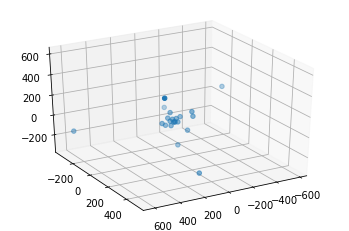

In [88]:
from sklearn.manifold import MDS

embedding = MDS(n_components=3, dissimilarity='precomputed')
X_transformed = embedding.fit_transform(inter_chrom_counts)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_transformed[:,0], X_transformed[:,1], X_transformed[:,2])

ax.view_init(30, 60)


## Problem 2.2

### (a)

### (b)

### (c)